In [1]:
using LinearAlgebra
using SparseArrays
using Plots
using Random
using FFTW
using Statistics
using CurveFit

## Base code
Maxwell's equations were an important development in ninteenth-century physics, demonstrating that electricity and magnetism are intrinsically linked as one fundamental force. Accurately modelling these equations is crucial for current technologies, theory work, and experimental physics. The first step is looking at the one-dimensional case, where an algorithm can be built to study the evolution of magnetic and electric fields through time. Complexities can be added from here.

For the 1D model, a mixed method is implemented. The implicit Crank-Nicolson (CN) method is used to solve for the electric field,

$$\frac{\partial E_z}{\partial t} = \frac{-1}{\epsilon} \frac{\partial B_y}{\partial x}$$

and update equation for unknown $E^{n+1}$, with $\alpha = \frac{c^2 \Delta t^2}{2 \Delta x^2}$:
$$E^{n+1}_i - \alpha \left( E^{n+1}_{i+1} -2 E^{n+1}_{i} + E^{n+1}_{i-1} \right) = 2 E^n_i - E^{n-1}_i + \alpha \left(E^{n-1}_{i+1} - 2 E^{n-1}_{i} + E^{n-1}_{i-1} \right) .$$

We have a known vector $b$ from previous time steps and enforced boundary conditions:
$$
b_i = (1+2\alpha)E^{n+1}_{i} - \alpha E^{n+1}_{i+1} - \alpha E^{n+1}_{i-1}
$$

and elements in tridiagonal matrix $A$:
$$
a_{i,i} = 1+\alpha_{i-1} + \alpha_i, \; a_{i, i-1} = -\alpha_{i-1}, \; a_{i, i+1} = -\alpha_i
$$

to complete the requirements to move forward with the CN method.

An explicit standard Yee FDTD method is used to study the propagation of the magnetic field

$$
\frac{\partial B_y}{\partial t} = \frac{-1}{\mu} \frac{\partial E_z}{\partial x}
$$

and for second-order accuracy, centred differences in time and space is used to generate the update equation:
$$
\frac{B^{n+1/2}_{i+1/2} - B^{n-1/2}{i+1/2}}{\Delta t} = \frac{-1}{\mu} \frac{E^n{i+1} - E^n_i}{\Delta x}
$$

alongside meeting the Courant-Friedrichs-Lewy (CFL) condition for stability:
$$\alpha = \frac{c\Delta t}{\Delta x} \leq 1$$

where $c$ is the wave speed in a specific medium, $\Delta x$ is the spatial step, and $\Delta t$ is the time step. Usually $\alpha$ is chosen to be $\leq 0.9$ to provide a safety buffer.

In [57]:
# Implimenting the CN and Yee methods to solve for the propagation on an EM wave in a cavity
function build_A_CN(nx_int, α)
    main  = zeros(Float64, nx_int)
    lower = zeros(Float64, nx_int-1)
    upper = zeros(Float64, nx_int-1)

    for j in 1:nx_int
        if j < nx_int
            upper[j] = -α[j+2]
        end
        if j > 1
            lower[j-1] = -α[j+1]
        end
        main[j] = 1.0 + α[j+1] + α[j+2]
    end
    return Tridiagonal(lower, main, upper)
end

function build_b_CN(nx_int, time, α, E)
    b = zeros(Float64, nx_int)
    for j in 1:nx_int
        b[j] = 2.0*E[time, j+1] - E[time-1, j+1] +
               α[j+1] * (E[time-1, j]   - E[time-1, j+1]) +
               α[j+2] * (E[time-1, j+2] - E[time-1, j+1])
    end
    return b
end


function apply_E_BC!(E, itp1, nx, leftBC::String, rightBC::String)
    # ---- Left boundary ----
    if leftBC == "PEC"
        E[itp1, 1] = 0.0
    elseif leftBC == "PMC"
        E[itp1, 1] = E[itp1, 2]
    else
        error("Unknown left boundary condition: $leftBC")
    end

    # ---- Right boundary ----
    if rightBC == "PEC"
        E[itp1, nx] = 0.0
    elseif rightBC == "PMC"
        E[itp1, nx] = E[itp1, nx-1]
    else
        error("Unknown right boundary condition: $rightBC")
    end
end


function FDTD_1D(nx::Int, nt::Int, dx, dt, α, c, ϵ, μ, f; leftBC::String = "PEC", rightBC::String = "PEC")
    E = zeros(nt+1, nx)      # Electric field
    B = zeros(nt+1, nx-1)    # Magnetic field
    x = range(0.0, L, length = nx)

    # --- setting up initial conditions ---
    for ix in 1:nx
        E[2, ix] = f(x[ix])
    end

    # make E at t = 0 using ∂tE = c ∂xE
    dE_dx = zeros(Float64, nx)
    dE_dx[2:nx-1] .= (E[2, 3:nx] .- E[2, 1:nx-2]) ./ (2*dx)

    # ---- boundary derivatives ----
    if leftBC == "PEC"
        dE_dx[1] = (E[2, 2] - E[2, 1]) / dx
    elseif leftBC == "PMC"
        dE_dx[1] = 0.0
    end

    if rightBC == "PEC"
        dE_dx[nx] = (E[2, nx] - E[2, nx-1]) / dx
    elseif rightBC == "PMC"
        dE_dx[nx] = 0.0
    end

    E[1, :] .= E[2, :] .+ c .* dt .* dE_dx

    
    # making B field
    η = sqrt.(0.5 .* (μ[1:end-1] .+ μ[2:end]) ./
              (0.5 .* (ϵ[1:end-1] .+ ϵ[2:end])))

    E_mid = 0.5 .* (E[2, 1:end-1] .+ E[2, 2:end])
    B[1, :] .= E_mid ./ η


    # --- Crank-Nicolson for E ---
    μ_mid = 0.5 .* (μ[1:end-1] .+ μ[2:end])
    A = build_A_CN(nx - 2, α)
    F = lu(A)

    for it = 2:nt-1
        b = build_b_CN(nx - 2, it, α, E)
        E_interior = F \ b

        E[it+1, 2:nx-1] .= E_interior
        apply_E_BC!(E, it+1, nx, leftBC, rightBC)

        # ---- explicit update for B ----
        B[it+1, :] = B[it, :] .- (dt/2.0) .* ((E[it, 2:end]   .- E[it, 1:end-1]) .+ (E[it+1, 2:end] .- E[it+1, 1:end-1])) ./ (μ_mid .* dx)
    end
    return E, B
end

FDTD_1D (generic function with 1 method)

In [52]:
# Constants
# c = 299792458.0   # speed of light
ϵ0 = 8.8541878128e-12
μ0 = π*4e-7


# Creating grid
L = 1.0   # length of the domain [m]
nx = 401   # number of spatial steps
dx = L/(nx-1)   # space step
x = range(0.0, L, length = nx)   # spatial grid points
c_vac = 1/sqrt(μ0*ϵ0)   #"could also just use c0??"
dt = 0.9*dx/c_vac   # time step
nt = 500   # number of time steps


# Vacuum-water interface halfway through space
# non-magnetic materials so μ stays the same
ϵ = fill(ϵ0, nx)   # making a grid of vacuum
mid = floor(Int, nx/2)
ϵ[mid+1:end] .= ϵ0 * 80.0   # relative permittivity of water is 80

μ = fill(μ0, nx)

c2 = 1.0 ./ (μ .* ϵ)   # gives c^2 everywhere
cs = sqrt.(c2)
α = (c2 .* dt^2) / (2.0*dx^2)


# Initial shape
x0 = 0.2*L   # centre of pulse
σ = 0.03*L   # width
gaussian(x) = exp(-(x-x0)^2 / (2σ^2))


E, B = FDTD_1D(nx, nt, dx, dt, α, cs, ϵ, μ, gaussian)
println("done")

done


In [4]:
it_snap = 400
p = plot(x, E[it_snap, :],
         ylim = (-1.5, 1.5),
         xlabel = "x (m)",
         ylabel = "E_z (a.u.)",
         title = "E field at time step $it_snap / $nt",
         legend = false)
vline!(p, [x[mid]], linestyle = :dash)
savefig(p, "E_t$(it_snap).png")


# xB = x[1:end-1] .+ 0.5*dx
# p = plot(xB, B[it_snap, :],
#          ylim = (-1.5, 1.5),
#          xlabel = "x (m)",
#          ylabel = "B_y (a.u.)",
#          title = "B field at time step $it_snap / $nt",
#          legend = false)
# vline!(p, [x[mid]], linestyle = :dash)
# savefig(p, "B_t$(it_snap).png")

"C:\\Users\\ashwa\\GitHUB\\PHYS 420\\1D Maxwell's Equations with CN and Yee Mixed Methods\\E_t400.png"

In [53]:
# For E
anim = @animate for it in 1:nt+1
    plot(x, E[it, :],
         ylim=(-1.5, 1.5),
         xlabel="x (m)",
         ylabel="E_z (a.u.)",
         title="E field at time step $it / $nt",
         legend=false)
    vline!([x[mid]], linestyle=:dash)
end
mp4(anim, "anim_mine_E.mp4", fps = 50)

# # Also save final snapshot to PNG
# png("sc_mine_E.png", size=(800,300))
# println("Animation saved to: ", "anim_mine_E.mp4")
# println("Final snapshot saved to: cn_fdtd_final_snapshot.png")


# For B
xB = x[1:end-1] .+ 0.5*dx
anim = @animate for it in 1:nt
    plot(xB, B[it, :],
         ylim=(-1.5, 1.5),
         xlabel="x (m)",
         ylabel="B_y (a.u.)",
         title="B field at time step $it / $nt",
         legend=false)
    vline!([x[mid]], linestyle=:dash)
end
mp4(anim, "anim_mine_B.mp4", fps = 50)

println("done!")

# # Also save final snapshot to PNG
# png("sc_mine_E.png", size=(800,300))
# println("Animation saved to: ", "anim_mine_E.mp4")
# println("Final snapshot saved to: cn_fdtd_final_snapshot.png")

[ Info: Saved animation to C:\Users\ashwa\GitHUB\PHYS 420\1D Maxwell's Equations with CN and Yee Mixed Methods\anim_mine_E.mp4


done!


[ Info: Saved animation to C:\Users\ashwa\GitHUB\PHYS 420\1D Maxwell's Equations with CN and Yee Mixed Methods\anim_mine_B.mp4


In [58]:
# PMC Conditions
ϵ_PMC = fill(ϵ0, nx)
# mid = floor(Int, nx/2)
# ϵ_PMC[1:mid+1] .= ϵ0


μ_PMC = fill(μ0 / 10.0, nx)
# mid = floor(Int, nx/2)
# μ_PMC[1:mid+1] .= μ0
# μ_PMC[mid+1:end] .= μ0

c2_PMC = 1.0 ./ (μ_PMC .* ϵ_PMC)
cs_PMC = sqrt.(c2_PMC)
α_PMC = (c2_PMC .* dt^2) / (2.0*dx^2)

# E_PMC, B_PMC = FDTD_1D(nx, nt, dx, dt, α, cs, ϵ, μ, gaussian; leftBC="PMC", rightBC="PMC")

E_PMC, B_PMC = FDTD_1D(nx, nt, dx, dt, α_PMC, cs_PMC, ϵ_PMC, μ_PMC, gaussian; leftBC = "PMC", rightBC = "PMC")
println("done")

done


In [59]:
# p = plot(x, E_PMC[it_snap, :],
#          ylim = (-1.5, 1.5),
#          xlabel = "x (m)",
#          ylabel = "E_z (a.u.)",
#          title = "E field at time step $it_snap / $nt",
#          legend = false)
# vline!(p, [x[mid]], linestyle = :dash)
# savefig(p, "E_PMC_t$(it_snap).png")


# p = plot(xB, B_PMC[it_snap, :],
#          ylim = (-1.5, 1.5),
#          xlabel = "x (m)",
#          ylabel = "B_y (a.u.)",
#          title = "B field at time step $it_snap / $nt",
#          legend = false)
# vline!(p, [x[mid]], linestyle = :dash)
# savefig(p, "B_PMC_t$(it_snap).png")

In [60]:
# For E
anim = @animate for it in 1:nt+1
    plot(x, E_PMC[it, :],
         ylim=(-1.5, 1.5),
         xlabel="x (m)",
         ylabel="E_z (a.u.)",
         title="E field at time step $it / $nt",
         legend=false)
    vline!([x[mid]], linestyle=:dash)
end
mp4(anim, "anim_E_PMC.mp4", fps = 50)

# Also save final snapshot to PNG
# png("sc_E_PMC.png", size=(800,300))
# println("Animation saved to: ", "anim_E_PMC.mp4")
# println("Final snapshot saved to: cn_fdtd_final_snapshot.png")


# For B
xB = x[1:end-1] .+ 0.5*dx
anim = @animate for it in 1:nt
    plot(xB, B_PMC[it, :],
         ylim=(-1.5, 1.5),
         xlabel="x (m)",
         ylabel="B_y (a.u.)",
         title="B field at time step $it / $nt",
         legend=false)
    vline!([x[mid]], linestyle=:dash)
end
mp4(anim, "anim_B_PMC.mp4", fps = 50)

println("done!")

# # Also save final snapshot to PNG
# png("sc_B_PMC.png", size=(800,300))
# println("Animation saved to: ", "anim_B_PMC.mp4")
# println("Final snapshot saved to: cn_fdtd_final_snapshot.png")

[ Info: Saved animation to C:\Users\ashwa\GitHUB\PHYS 420\1D Maxwell's Equations with CN and Yee Mixed Methods\anim_E_PMC.mp4


done!


[ Info: Saved animation to C:\Users\ashwa\GitHUB\PHYS 420\1D Maxwell's Equations with CN and Yee Mixed Methods\anim_B_PMC.mp4


### Reflection Coefficient
The reflection, $R$, and transmission, $T$, coefficients describe the ratio of the reflected and transmission wave amplitude with respect to the amplitude of the incident wave and follow the following relation:
$$R + T = 1.$$

From Fresnel's equations in the 1D case, the coefficients can be written as
$$R = \frac{\eta_2 - \eta_1}{\eta_2 + \eta_1}, \; \; \; \; T = \frac{2\eta_2}{\eta_2 + \eta_1}$$
with $\eta$ representing the impedence of a medium, $\eta_i = \sqrt{\frac{\mu_i}{\epsilon_i}}$.

To calculate the numerical coefficients, a FFT can be used by choosing a specific spatial position and extracting the time-domain data for two simulations, one being the case without an interface, and the other with an interface. The homogeneous run can be subtracted from the interface run to isolate the reflected wave. Then the time-domain data can be transformed using an FFT to frequency-domain, then signal processing techniques such as Hann windowing and zero-padding can be used to improve the resulting resolution. Cross-correlation and fitting techniques can be used to refine peaks in the spectrum.

In [9]:
# Analytical
η_vacuum = sqrt(μ0/ϵ0)
η_water = sqrt(μ0/(80.0*ϵ0))
r_ana = abs.(η_water - η_vacuum) / (η_water + η_vacuum)
println("The analytical reflection coefficient is ", round(r_ana, digits = 3))

The analytical reflection coefficient is 0.799


In [10]:
# Numerical
ϵ0_bare = fill(ϵ0, nx)
c2_bare = 1.0 ./ (μ .* ϵ0_bare)
cs_bare = sqrt.(c2_bare)
α_bare = (c2_bare .* dt^2) / (2.0*dx^2)
E_bare, _ = FDTD_1D(nx, nt, dx, dt, α_bare, cs_bare, ϵ0_bare, μ, gaussian)

E_inc = E_bare[1:275, Int(L/(2*dx) * 0.625)]   # incident wave
E_ref = E[1:275, Int(L/(2*dx) * 0.625)] .- E_bare[1:275, Int(L/(2*dx) * 0.625)]   # reflected part only

E_inc_ω = fft(E_inc)
E_ref_ω = fft(E_ref)

R = E_ref_ω ./ E_inc_ω   # complex reflection coefficient

# Total reflected energy fraction - this is the most physically accurate and should work for broadband pulses
R_energy = sum(abs.(E_ref_ω).^2) / sum(abs.(E_inc_ω).^2)

# checking specifically at the dominant frequency
# nice to compare against Fresnel's
i0 = argmax(abs.(E_inc_ω))
R0 = abs(R[i0])

println("The reflection coefficient using the total reflected energy fraction is ", round(sqrt.(R_energy), digits = 3))
println("Using the dominant frequency to check ", round(R0, digits = 3))
println("Both are incredibly close to the analytical value, especially the latter method")

The reflection coefficient using the total reflected energy fraction is 0.806
Using the dominant frequency to check 0.799
Both are incredibly close to the analytical value, especially the latter method


### Convergence Test
Second-order accuracy can be checked via a convergence study by comparing the result from a simulation in homogeneous medium and the same scenario analytically, such as with a propagating Gaussian pulse:
$$ E(x, t) = exp \left( - \frac{(x-x_0-ct)^2}{2\sigma^2} \right)$$
Then the root-mean-squared error can be computed for a specified time:
$$L_2 (\Delta x) = \sqrt{\sum \left( E_{num} - E_{exact}\right)^2 \Delta x}$$
Finer spatial step values can be evaluated for, then plotted on a log-log plot where the slope should be two if second-order accurate.

Slope:1.0176104236891974
The numerical slope represents first-order behaviour, whereas we wanted a slope
of 2 to show second-order accuracy. This could be due to errors in the phase or time or
potential boundary effects.



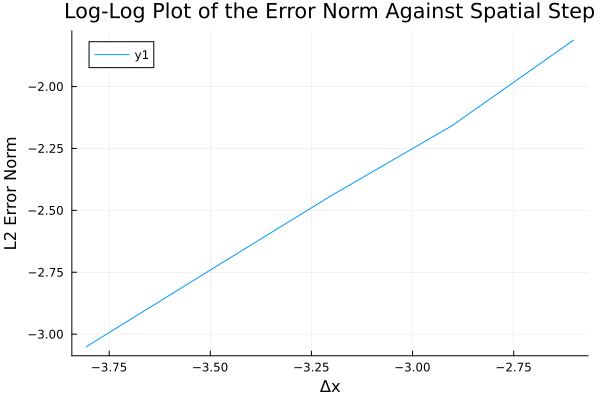

In [11]:
function initalize_bare(factor, L, nx, nt, dx, dt, ϵ0, μ0, E_ana; quit = false)
    x_bare = range(0.0, L, length = nx*factor)   # spatial grid points
    ϵ_bare = fill(ϵ0, nx*factor)   # making a grid of vacuum
    μ_bare = fill(μ0, nx*factor)
    c2_bare = 1.0 ./ (μ_bare .* ϵ_bare)
    cs_bare = sqrt.(c2_bare)

    α_bare = (c2_bare .* (dt/factor)^2) / (2.0*(dx/factor)^2)
    E_bare, B_bare = FDTD_1D(nx*factor, nt, dx/factor, dt/factor, α_bare, cs_bare, ϵ_bare, μ_bare, gaussian)

    if quit == true
        return dx/factor, dt/factor, nx*factor, nt, ϵ_bare, μ_bare, E_bare, B_bare
    end

    analytical_E = zeros(Float64, (nt, nx*factor))
    for it in 1:nt
        analytical_E[it, :] = E_ana(cs_bare, x_bare, (dt/factor) * it)
    end

    return E_bare[2:end, :], analytical_E
end


function error_norm(E_num, E_exact, Δx)
    diff = (E_num .- E_exact) .^ 2 .* Δx
    return sqrt(sum(diff))
end


E_ana(c, x, t) = exp.(-(x .-x0 .-c .*t) .^2 ./(2σ^2))

factors = [1, 2, 4, 8, 16]
Δx = zeros(length(factors))
err = zeros(length(factors))
time_step = 200

for i in 1:length(factors)
    E_num, E_exact = initalize_bare(factors[i], L, nx, nt, dx, dt, ϵ0, μ0, E_ana)
    Δx[i] = dx/factors[i]
    err[i] = error_norm(E_num[time_step, :], E_exact[time_step, :], Δx[i])
end


p = hcat(ones(length(log10.(Δx))), log10.(Δx)) \ log10.(err)
slope = p[2]
intercept = p[1]

println("Slope:", p[2])
println("The numerical slope represents first-order behaviour, whereas we wanted a slope
of 2 to show second-order accuracy. This could be due to errors in the phase or time or
potential boundary effects.")
println("")

p = plot(log10.(Δx), log10.(err), xlabel = "Δx", ylabel = "L2 Error Norm", title = "Log-Log Plot of the Error Norm Against Spatial Step")
savefig(p, "convergence.png")
display(p)

### Energy Conservation
With a lossless media without an active source, the electromagnetic energy throughout should be conserved. The total energy as a fraction of time:
$$U(t) = \int (\epsilon E^2 + \frac{1}{\mu} B^2)dx$$
should be held constant to show the numerical scheme adheres to physical conservation laws.

Energy variation: min=0.0, max=1.5091455269538558
Since a source is injected, there is a jump in the total amount of energy. However, for the remainder of the simulation, it holds relatively constant, showing energy conservation and validating the scheme used.


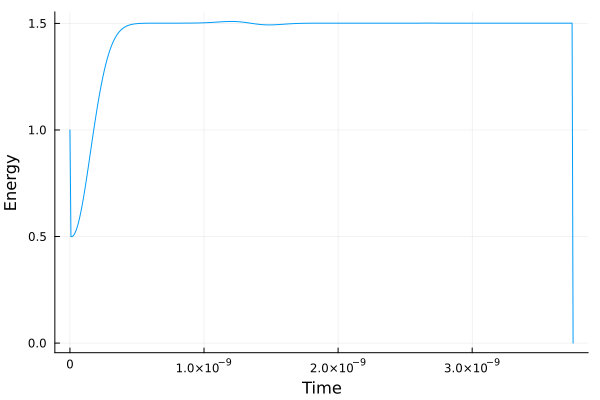

In [12]:
function energy_cons(dx, dt, nx, nt, ϵ, μ, E, B)
    U = zeros(nt+1)
    for it = 1:nt+1
        Ue = 0.5 * sum(ϵ .* (E[it, :].^2)) * dx
        μ_mid = 0.5 .* (μ[1:end-1] .+ μ[2:end])
        Ub = 0.5 * sum(μ_mid .* (B[it, :].^2)) * dx
        U[it] = Ue + Ub
    end

    plot((0:nt).*dt, U ./ U[1], xlabel="time (s)", ylabel="Normalized total energy", label="U(t)/U(0)")
    println("Energy variation: min=$(minimum(U)/U[1]), max=$(maximum(U)/U[1])")
    return (U=U)
end


dx_cons, dt_cons, nx_cons, nt_cons, ϵ_cons, μ_cons, E_cons, B_cons = initalize_bare(1, L, nx, nt, dx, dt, ϵ0, μ0, E_ana; quit = true)
res_energy = energy_cons(dx_cons, dt_cons, nx_cons, nt_cons, ϵ_cons, μ_cons, E_cons, B_cons)

println("Since a source is injected, there is a jump in the total amount of energy. However, for the remainder of the simulation, it holds relatively constant, showing energy conservation and validating the scheme used.")

t = range(0.0, nt_cons*dt_cons, length = nt_cons+1)
p = plot(t, res_energy/res_energy[1], xlabel = "Time", ylabel = "Energy", legend = false)#, xscale = log10, yscale = log10)
savefig(p, "energy.png")
display(p)

## Different initial conditions
Different source pulses (ricker, chirp).

In [13]:
# Initial conditions - different pulses
x0 = 0.2*L   # centre of pulse
σ = 0.03*L   # width
gaussian(x) = exp(-(x-x0)^2 / (2σ^2))

PPW = 90   # for low f (PPW ~ 30-200), for high f (PPW ~ 5-20)
f0 = 1/(dx*PPW)
ricker(x) = (1-2*(π*f0*(x-x0))^2) * exp(-(π*f0*(x-x0))^2)

# wavenumber, k_max = π/(10*Δx)
k = rand() * (π/(10*dx))
chirp(x) = exp(-(x-x0)^2/(2σ^2)) * cos(2*π*(f0+k*(x-x0)) * (x-x0))

chirp (generic function with 1 method)

In [14]:
E, B = FDTD_1D(nx, nt, dx, dt, α, cs, ϵ, μ, ricker)

p = plot(x, E[it_snap, :],
         ylim = (-1.5, 1.5),
         xlabel = "x (m)",
         ylabel = "E_z (a.u.)",
         title = "E field at time step $it_snap / $nt (Ricker)",
         legend = false)
vline!(p, [x[mid]], linestyle = :dash)
savefig(p, "E_ricker$(it_snap).png")


# p = plot(xB, B[it_snap, :],
#          ylim = (-1.5, 1.5),
#          xlabel = "x (m)",
#          ylabel = "B_y (a.u.)",
#          title = "B field at time step $it_snap / $nt (Ricker)",
#          legend = false)
# vline!(p, [x[mid]], linestyle = :dash)
# savefig(p, "B_ricker$(it_snap).png")


# For E
anim = @animate for it in 1:nt+1
    plot(x, E[it, :],
         ylim=(-1.5, 1.5),
         xlabel="x (m)",
         ylabel="E_z (a.u.)",
         title="E field at time step $it / $nt",
         legend=false)
    vline!([x[mid]], linestyle=:dash)
end
mp4(anim, "ricker_E.mp4", fps = 50)


# For B
xB = x[1:end-1] .+ 0.5*dx
anim = @animate for it in 1:nt
    plot(xB, B[it, :],
         ylim=(-1.5, 1.5),
         xlabel="x (m)",
         ylabel="B_y (a.u.)",
         title="B field at time step $it / $nt",
         legend=false)
    vline!([x[mid]], linestyle=:dash)
end
mp4(anim, "ricker_B.mp4", fps = 50)

println("done!")

[ Info: Saved animation to C:\Users\ashwa\GitHUB\PHYS 420\1D Maxwell's Equations with CN and Yee Mixed Methods\ricker_E.mp4


done!


[ Info: Saved animation to C:\Users\ashwa\GitHUB\PHYS 420\1D Maxwell's Equations with CN and Yee Mixed Methods\ricker_B.mp4


In [15]:
E, B = FDTD_1D(nx, nt, dx, dt, α, cs, ϵ, μ, chirp)

p = plot(x, E[it_snap, :],
         ylim = (-1.5, 1.5),
         xlabel = "x (m)",
         ylabel = "E_z (a.u.)",
         title = "E field at time step $it_snap / $nt (Chirp)",
         legend = false)
vline!(p, [x[mid]], linestyle = :dash)
savefig(p, "E_chirp$(it_snap).png")


# p = plot(xB, B[it_snap, :],
#          ylim = (-1.5, 1.5),
#          xlabel = "x (m)",
#          ylabel = "B_y (a.u.)",
#          title = "B field at time step $it_snap / $nt (Chirp)",
#          legend = false)
# vline!(p, [x[mid]], linestyle = :dash)
# savefig(p, "B_chirp$(it_snap).png")

# For E
anim = @animate for it in 1:nt+1
    plot(x, E[it, :],
         ylim=(-1.5, 1.5),
         xlabel="x (m)",
         ylabel="E_z (a.u.)",
         title="E field at time step $it / $nt",
         legend=false)
    vline!([x[mid]], linestyle=:dash)
end
mp4(anim, "chirp_E.mp4", fps = 50)


# For B
xB = x[1:end-1] .+ 0.5*dx
anim = @animate for it in 1:nt
    plot(xB, B[it, :],
         ylim=(-1.5, 1.5),
         xlabel="x (m)",
         ylabel="B_y (a.u.)",
         title="B field at time step $it / $nt",
         legend=false)
    vline!([x[mid]], linestyle=:dash)
end
mp4(anim, "chirp_B.mp4", fps = 50)

println("done!")

[ Info: Saved animation to C:\Users\ashwa\GitHUB\PHYS 420\1D Maxwell's Equations with CN and Yee Mixed Methods\chirp_E.mp4


done!


[ Info: Saved animation to C:\Users\ashwa\GitHUB\PHYS 420\1D Maxwell's Equations with CN and Yee Mixed Methods\chirp_B.mp4


## Interface conditions
Two interfaces.

In [16]:
# Vacuum-water-ferrite interface
ϵ3 = fill(ϵ0, nx)
third = floor(Int, nx/3)
ϵ3[third:2*third] .= ϵ0 * 80.0   # relative permittivity of water is 80
ϵ3[2*third:end] .= ϵ0 * 1.0   # ferrite (moderate magnetic + dielectric)   (10)

μ3 = fill(μ0, nx)   # water relative permeability ~ 1
μ3[2*third:end] .= μ0 * 100.0   # ferrite (moderate magnetic + dielectric)   (200)

c2 = 1.0 ./ (μ3 .* ϵ3)   # gives c^2 everywhere
cs = sqrt.(c2)
β = (c2 .* dt^2) / (2.0*dx^2)


# Initial shape
x0 = 0.2*L   # centre of pulse
σ = 0.03*L   # width
gaussian(x) = exp(-(x-x0)^2 / (2σ^2))

E, B = FDTD_1D(nx, nt, dx, dt, β, cs, ϵ3, μ3, gaussian)
println("done")

done


In [17]:
p = plot(x, E[it_snap, :],
         ylim = (-1.5, 1.5),
         xlabel = "x (m)",
         ylabel = "E_z (a.u.)",
         title = "E field at time step $it_snap / $nt",
         legend = false)
vline!(p, [x[mid]], linestyle = :dash)
savefig(p, "E_3interface$(it_snap).png")


# p = plot(xB, B[it_snap, :],
#          ylim = (-1.5, 1.5),
#          xlabel = "x (m)",
#          ylabel = "B_y (a.u.)",
#          title = "B field at time step $it_snap / $nt",
#          legend = false)
# vline!(p, [x[mid]], linestyle = :dash)
# savefig(p, "B_3interface$(it_snap).png")


# For E
anim = @animate for it in 1:nt+1
    plot(x, E[it, :],
         ylim=(-1.5, 1.5),
         xlabel="x (m)",
         ylabel="E_z (a.u.)",
         title="E field at time step $it / $nt",
         legend=false)
    vline!([x[third]], linestyle=:dash)
    vline!([x[2*third]], linestyle=:dash)
end
mp4(anim, "3_interface_E.mp4", fps = 50)


# For B
xB = x[1:end-1] .+ 0.5*dx
anim = @animate for it in 1:nt
    plot(xB, B[it, :],
         ylim=(-1.5, 1.5),
         xlabel="x (m)",
         ylabel="B_y (a.u.)",
         title="B field at time step $it / $nt",
         legend=false)
    vline!([x[third]], linestyle=:dash)
    vline!([x[2*third]], linestyle=:dash)
end
mp4(anim, "3_interface_B.mp4", fps = 50)

println("done!")

[ Info: Saved animation to C:\Users\ashwa\GitHUB\PHYS 420\1D Maxwell's Equations with CN and Yee Mixed Methods\3_interface_E.mp4


done!


[ Info: Saved animation to C:\Users\ashwa\GitHUB\PHYS 420\1D Maxwell's Equations with CN and Yee Mixed Methods\3_interface_B.mp4


## 2D Gaussian Pulse

#### Explicit update equations
$$Bx^{n+1/2}(i,j) = Bx^{n-1/2}(i,j) - (dt/μ) * (E_z^n(i,j+1)-E_z^n(i,j))/Δy$$
$$By^{n+1/2}(i,j) = By^{n-1/2}(i,j) + (dt/μ) * (E_z^n(i+1,j)-E_z^n(i,j))/Δx$$
$$E_z^{n+1}(i,j) = E_z^n(i,j) + (dt/ε) * [ (By^{n+1/2}(i,j)-By^{n+1/2}(i-1,j))/Δx
                                        - (Bx^{n+1/2}(i,j)-Bx^{n+1/2}(i,j-1))/Δy ]$$

In [18]:
function build_A_CN_2D(nx_int, ny_int, α_grid, bc=:PEC)
    "Builds sparse CN matrix for interior nodes with PEC or PMC BCs"
    N = nx_int * ny_int
    rows = Int[]
    cols = Int[]
    vals = Float64[]

    for j in 1:ny_int
        for i in 1:nx_int
            k = i + (j-1)*nx_int
            α = α_grid[i,j]
            center = 1.0 + 4.0*α
            push!(rows, k); push!(cols, k); push!(vals, center)

            # left
            if i > 1
                push!(rows, k); push!(cols, k-1); push!(vals, -α)
            else
                if bc == :PMC
                    push!(rows, k); push!(cols, k); push!(vals, α)
                end
            end

            # right
            if i < nx_int
                push!(rows, k); push!(cols, k+1); push!(vals, -α)
            else
                if bc == :PMC
                    push!(rows, k); push!(cols, k); push!(vals, α)
                end
            end

            # down (j>1)
            if j > 1
                push!(rows, k); push!(cols, k-nx_int); push!(vals, -α)
            else
                if bc == :PMC
                    push!(rows, k); push!(cols, k); push!(vals, α)
                end
            end

            # up (j < ny_int)
            if j < ny_int
                push!(rows, k); push!(cols, k+nx_int); push!(vals, -α)
            else
                if bc == :PMC
                    push!(rows, k); push!(cols, k); push!(vals, α)
                end
            end
        end
    end

    A = sparse(rows, cols, vals, N, N)
    return A
end


function build_b_CN_2D(E_prev::Array{Float64,2}, E_curr::Array{Float64,2}, nx_int, ny_int, α_grid)
    "Builds vector b for CN update"
    b = zeros(nx_int * ny_int)
    idx = 1
    for j in 2:ny_int+1
        for i in 2:nx_int+1
            α = α_grid[i-1, j-1]
            lap_prev = (E_prev[i+1,j] + E_prev[i-1,j] + E_prev[i,j+1] + E_prev[i,j-1] - 4.0*E_prev[i,j])
            b[idx] = 2.0*E_curr[i,j] - E_prev[i,j] + α * lap_prev
            idx += 1
        end
    end
    return b
end


function FDTD_2D_TMz_CN(nx::Int, ny::Int, nt::Int, Lx, Ly, dt; bc=:PEC, rel_eps_right=80.0, init_fn = (x,y)->0.0)
    dx = Lx/(nx-1)
    dy = Ly/(ny-1)
    x = range(0.0, Lx, length=nx)
    y = range(0.0, Ly, length=ny)

    # constants
    ϵ0 = 8.8541878128e-12
    μ0 = π*4e-7

    # grid
    eps = fill(ϵ0, nx, ny)
    mu  = fill(μ0,  nx, ny)
    # interface in middle with water
    midx = fld(nx,2)
    for j in 1:ny
        for i in midx+1:nx
            eps[i,j] = ϵ0 * rel_eps_right
        end
    end

    c2 = 1.0 ./ (eps .* mu)
    c = sqrt.(c2)

    Ez_prev = zeros(nx, ny)   # E^{n-1}
    Ez_curr = zeros(nx, ny)   # E^{n}
    Ez_next = zeros(nx, ny)   # E^{n+1}

    # B arrays on staggered positions
    Bx = zeros(nx, ny-1)
    By = zeros(nx-1, ny)
    
    Ez_hist = zeros(nt+1, nx, ny)
    Bx_hist = zeros(nt+1, nx, ny-1)
    By_hist = zeros(nt+1, nx-1, ny)

    # --- initial condition ---
    for j in 1:ny, i in 1:nx
        Ez_curr[i,j] = init_fn(x[i], y[j])
    end
    # initial time derivative (standing start)
    Ez_prev .= Ez_curr

    # apply BCs
    function apply_BC!(E)
        if bc == :PEC
            # Dirichlet Ez = 0 on boundaries
            E[1,:] .= 0.0
            E[end,:] .= 0.0
            E[:,1] .= 0.0
            E[:,end] .= 0.0
        elseif bc == :PMC
            # Neumann: mirror inside values
            E[1,:] .= E[2,:]
            E[end,:] .= E[end-1,:]
            E[:,1] .= E[:,2]
            E[:,end] .= E[:,end-1]
        end
    end

    apply_BC!(Ez_prev)
    apply_BC!(Ez_curr)
    Ez_hist[1, :, :] .= Ez_prev
    Ez_hist[2, :, :] .= Ez_curr

    nx_int = nx - 2
    ny_int = ny - 2
    α_grid = zeros(nx_int, ny_int)
    for j in 1:ny_int, i in 1:nx_int
        ip = i+1; jp = j+1
        α_grid[i,j] = (c2[ip,jp] * dt^2) / (2.0 * dx^2)
    end

    # --- matrix A ---
    A = build_A_CN_2D(nx_int, ny_int, α_grid, bc)

    for n in 2:nt
        b = build_b_CN_2D(Ez_prev, Ez_curr, nx_int, ny_int, α_grid)
        E_interior_next = A \ b

        idx = 1
        for j in 2:ny-1, i in 2:nx-1
            Ez_next[i,j] = E_interior_next[idx]; idx += 1
        end

        apply_BC!(Ez_next)

        # Bx field
        for j in 1:ny-1, i in 1:nx
            dEdy_n  = (Ez_curr[i, j+1] - Ez_curr[i, j]) / dy
            dEdy_np = (Ez_next[i, j+1] - Ez_next[i, j]) / dy
            μ_loc = 0.5*(mu[i, j] + mu[i, j+1])
            Bx[i,j] = Bx[i,j] - (dt / (2.0 * μ_loc)) * (dEdy_n + dEdy_np)
        end

        # By field
        for j in 1:ny, i in 1:nx-1
            dEdx_n  = (Ez_curr[i+1, j] - Ez_curr[i, j]) / dx
            dEdx_np = (Ez_next[i+1, j] - Ez_next[i, j]) / dx
            μ_loc = 0.5*(mu[i, j] + mu[i+1, j])
            By[i,j] = By[i,j] + (dt / (2.0 * μ_loc)) * (dEdx_n + dEdx_np)
        end

        Ez_hist[n+1, :, :] .= Ez_next
        Bx_hist[n+1, :, :] .= Bx
        By_hist[n+1, :, :] .= By

        Ez_prev .= Ez_curr
        Ez_curr .= Ez_next
    end
    return Ez_hist, Bx_hist, By_hist, x, y
end


Lx = 1.0
Ly = 1.0
nx = 101
ny = 101
dx = Lx/(nx-1)
dy = Ly/(ny-1)

# physical constants
ϵ0 = 8.8541878128e-12
μ0 = π*4e-7
c0 = 1/sqrt(ϵ0*μ0)
dt = 0.7 * dx / (c0 * sqrt(2.0))
nt = 500

x0 = 0.2*Lx; y0 = 0.5*Ly; sigma = 0.03*Lx
gauss(x,y) = 5*exp(-((x-x0)^2 + (y-y0)^2)/(2.0*sigma^2))


Ez_hist, Bx_hist, By_hist, xgrid, ygrid = FDTD_2D_TMz_CN(nx, ny, nt, Lx, Ly, dt; bc=:PEC, rel_eps_right=3.0, init_fn = gauss)
println("done")

done


In [19]:
it_snap = 200
p = heatmap(xgrid, ygrid, Ez_hist[it_snap, :, :]',
            xlabel = "x (m)",
            ylabel = "y (m)",
            title = "Ez at time step $it_snap / $nt",
            aspect_ratio = 1,
            clims = (-1, 1),
            color = :starrynight)
vline!(p, [0.5], color = :white, linewidth = 2, linestyle = :dash)
savefig(p, "Ez_2D_t$(it_snap).png")

# it_snap = 200
# p = heatmap(x_2D, y_2D, Ez_hist[it_snap, :, :]',
#             xlabel = "x (m)",
#             ylabel = "y (m)",
#             title = "Ez at time step $it_snap / $nt",
#             aspect_ratio = 1,
#             clims = (-1, 1),
#             color = :redblue)
# vline!(p, [0.5], color = :white, linewidth = 2, linestyle = :dash)
# savefig(p, "Ez_2D_t$(it_snap).png")


x_2D = range(0.0, Lx, length = nx)
y_2D = range(0.0, Ly, length = ny)

anim = @animate for it in 1:nt
    heatmap(x_2D, y_2D, Ez_hist[it, :, :]',
            xlabel="x (m)",
            ylabel="y (m)",
            title="Ez at time step $it / $nt",
            aspect_ratio=1,
            clims=(-1,1),   # optional, keeps color scale fixed
            color=:redblue)   # looks good for EM waves
    vline!([0.5], color=:white, linewidth=2, linestyle=:dash)
end
mp4(anim, "Ez_2D.mp4", fps = 40)
println("done")

done


[ Info: Saved animation to C:\Users\ashwa\GitHUB\PHYS 420\1D Maxwell's Equations with CN and Yee Mixed Methods\Ez_2D.mp4


In [20]:
# Ez_hist_PMC, Bx_hist_PMC, By_hist_PMC, xgrid_PMC, ygrid_PMC = FDTD_2D_TMz_CN(nx, ny, nt, Lx, Ly, dt; bc=:PMC, rel_eps_right=3.0, init_fn = gauss)

# it_snap = 200
# p = heatmap(xgrid_PMC, ygrid_PMC, Ez_hist_PMC[it_snap, :, :]',
#             xlabel = "x (m)",
#             ylabel = "y (m)",
#             title = "Ez at time step $it_snap / $nt",
#             aspect_ratio = 1,
#             clims = (-1, 1),
#             color = :starrynight)
# vline!(p, [0.5], color = :white, linewidth = 2, linestyle = :dash)

# savefig(p, "Ez_2D_PMC_t$(it_snap).png")